<a href="https://colab.research.google.com/github/emergency-help-me/Statistical-Learning-for-Data-Science-2/blob/main/lab09_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [ ]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [ ]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [ ]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

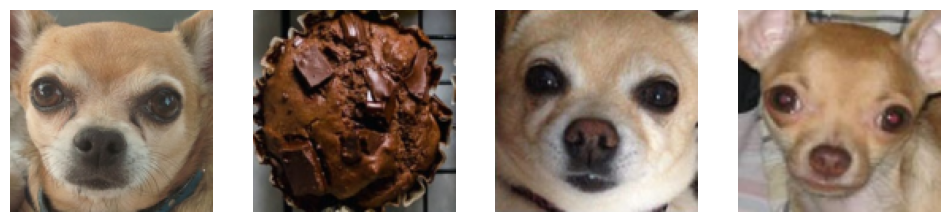

tensor([0, 1, 0, 0])


In [ ]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [ ]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.lin1 = nn.Linear(128*128*3,100)
    self.act1 = nn.ReLU()
    self.lin2 = nn.Linear(100,50)
    self.act2 = nn.ReLU()
    self.lin3 = nn.Linear(50,1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [ ]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [ ]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [ ]:
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [ ]:
X, y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [ ]:
y_hat = model(X)
y = y.to(torch.float32)
y_hat = y_hat[:, 0]

#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [ ]:
# Compute the loss
train_loss = criterion(y_hat, y)
train_losses.append(train_loss)

In [ ]:
train_losses

[tensor(11.5129, grad_fn=<DivBackward1>)]

#### Calculate the gradient (Backward pass)

In [ ]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
train_loss.backward()


In [ ]:
model.parameters()

<generator object Module.parameters at 0x7ca866f7f840>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
# Update the weights using the gradient descent rule
optimizer.step() #parameters - learing_rate * gradient_of_parameters

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    print(y_hat, y)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 0., 1.])


In [ ]:
print(train_losses)
print(val_losses)

[tensor(11.5129, grad_fn=<DivBackward1>)]
[38.13665008544922]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

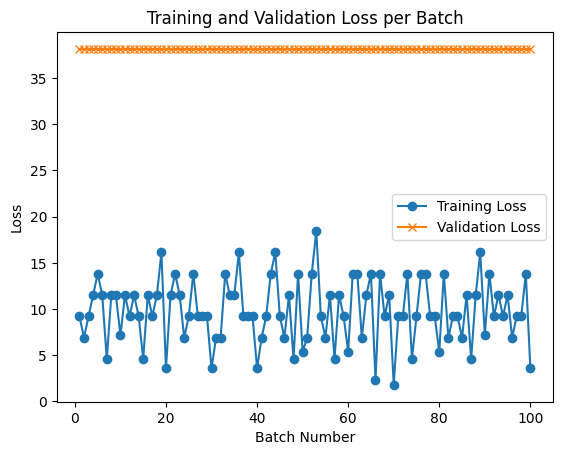

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

# Create a neural network with 3 hidden layers as shown in the picture.

In [ ]:
class ThreeLayerClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        # Input Layer: 128*128*3 -> Hidden 1: 128
        self.lin1 = nn.Linear(128 * 128 * 3, 128)
        self.act1 = nn.ReLU()

        # Hidden 1: 128 -> Hidden 2: 64
        self.lin2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()

        # Hidden 2: 64 -> Hidden 3: 32
        self.lin3 = nn.Linear(64, 32)
        self.act3 = nn.ReLU()

        # Hidden 3: 32 -> Output: 1
        self.lin4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.act1(self.lin1(x))
        x = self.act2(self.lin2(x))
        x = self.act3(self.lin3(x))
        x = self.lin4(x)
        return x

# Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5

In [ ]:
import torch
import torch.optim as optim

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
results = {}

for lr in learning_rates:
    model = ThreeLayerClassification()
    optimizer.zero_grad()      # ล้างค่า Gradient เก่า
    y_hat = model(X).squeeze() # Forward pass
    y = y.to(torch.float32)
    loss = criterion(y_hat, y) # 2. คำนวณ Loss จากผลต่างของ y_hat และ y
    loss.backward()            # 3. คำนวณ Gradient
    optimizer.step()           # 4. อัปเดต Weights
    train_losses.append(loss.item())

    results[lr] = train_losses
    print(f"LR {lr}: Final Loss = {train_losses[-1]:.4f}")


LR 0.01: Final Loss = 0.6938
LR 0.001: Final Loss = 0.6947
LR 0.0001: Final Loss = 0.6987
LR 1e-05: Final Loss = 0.6948


# 2.1 What value of learning rate do you think is the best? Please explain your reason.
 โดยส่วนใหญ่ค่า $1 \times 10^{-3}$
เป็นค่าที่ไม่ใหญ่เกินไปจนทำให้โมเดลข้ามจุดต่ำสุดของ Loss (Global Minimum) และไม่เล็กเกินไปจนทำให้การเรียนรู้หยุดนิ่ง

# 2.2 What happens to the training losses if your learning rate is too large?
ค่า Loss จะ ผันผวนอย่างรุนแรง หรือ พุ่งสูงขึ้น

#2.3 What happens to the training losses if your learning rate is too small?
ค่า Loss จะ ลดลงช้ามากจนเกือบเป็นเส้นตรง (Very Slow Convergence)

# 3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

In [ ]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_pred = (y_hat > 0.5).float()  # the predictions

  # Compute accuracy
  correct = (y_pred == y).sum().item()
  total = y.size(0)
  accuracy = correct / total
  print(f"Test Accuracy: {accuracy*100:.2f}%")

  # Collect incorrectly classified examples
  incorrect_indices = (y_pred != y).nonzero(as_tuple=True)[0]
  incorrect_examples = []
  for idx in incorrect_indices:
      incorrect_examples.append({
          'image': X[idx],
          'true_label': y[idx],
          'pred_label': y_pred[idx]
      })


Test Accuracy: 56.67%


#Use plt.imshow() to display at least four images that are incorrectly classified by this model.

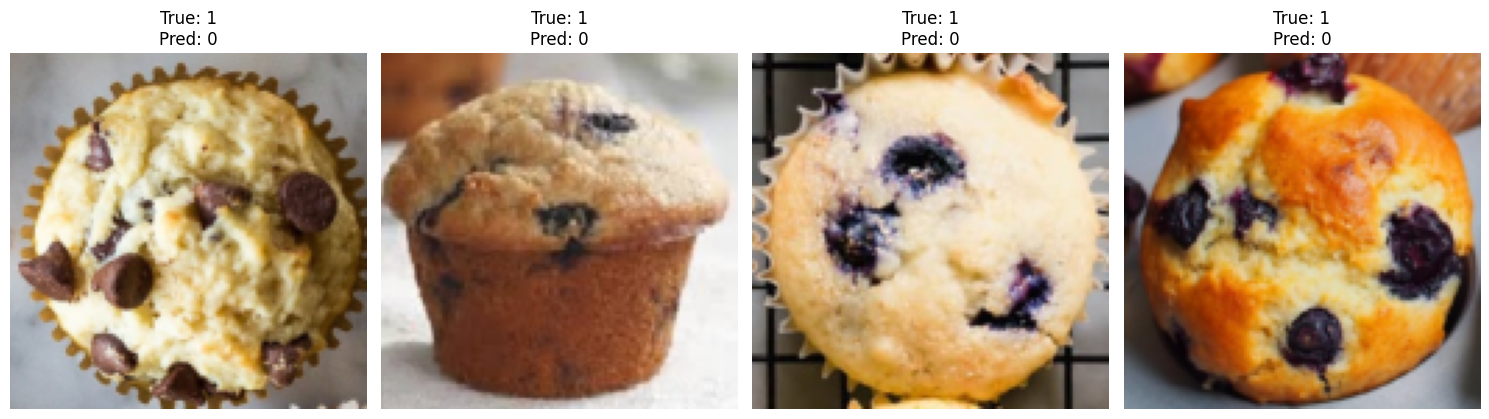

In [ ]:
# แสดงผลภาพที่ทายผิดอย่างน้อย 4 ภาพ
plt.figure(figsize=(15, 5))
num_to_show = min(4, len(incorrect_examples))

for i in range(num_to_show):
    ex = incorrect_examples[i]
    img = ex['image'].permute(1, 2, 0).cpu().numpy()

    # หากมีการทำ Normalization ไว้ตอนโหลด Data
    # อย่าลืมทำ Un-normalize เพื่อให้สีภาพกลับมาเป็นปกติ
    # img = img * std + mean

    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {int(ex['true_label'])}\nPred: {int(ex['pred_label'])}")
    plt.axis('off')

plt.tight_layout()
plt.show()